# Sector-Coupling with `pypsa`

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

:::{note}
Also in this tutorial, you might want to refer to the PyPSA documentation: https://pypsa.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via Google Colab. Click on the rocket in the top right corner and launch "Colab". If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa pandas numpy
```
:::

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
plt.style.use('bmh')

In [2]:
fn = "network-cem.nc"
url = "https://tubcloud.tu-berlin.de/s/kpWaraGc9LeaxLK/download/" + fn
urlretrieve(url, fn)

('network-cem.nc', <http.client.HTTPMessage at 0x7f9a24fa4050>)

## Previous Capacity Expansion Model

To explore sector-coupling options with PyPSA, let's load the capacity expansion model we built for the electricity system and add sector-coupling technologies and demands on top. 

This example has single node for Germany and 4-hourly temporal resolution for a year. It has wind and solar solar generation, an OCGT generator as well as battery and hydrogen storage to supply a fixed electricity demand.

Some sector-coupling technologies have multiple ouputs (e.g. CHP plants producing heat and power). By default, PyPSA links have only one input (`bus0`)
and one output (`bus1`) with a given efficieny (`efficiency`). Thus, we have to tell PyPSA that links can have multiple outputs by **overriding the component attributes**.

In [3]:
override_component_attrs = pypsa.descriptors.Dict(
    {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
)

In [4]:
override_component_attrs["Link"].loc["bus2"] = [
    "string",
    np.nan,
    np.nan,
    "2nd bus",
    "Input (optional)",
]
override_component_attrs["Link"].loc["efficiency2"] = [
    "static or series",
    "per unit",
    1.0,
    "2nd bus efficiency",
    "Input (optional)",
]
override_component_attrs["Link"].loc["p2"] = [
    "series",
    "MW",
    0.0,
    "2nd bus output",
    "Output",
]

In [5]:
override_component_attrs["Link"].tail()

,type,unit,default,description,status
attribute,,,,,
mu_upper,series,currency/MW,0,Shadow price of upper p_nom limit f \leq F. Al...,Output
mu_p_set,series,currency/MWh,0,Shadow price of fixed power transmission p_set,Output
bus2,string,NaN,NaN,2nd bus,Input (optional)
efficiency2,static or series,per unit,1.0,2nd bus efficiency,Input (optional)
p2,series,MW,0.0,2nd bus output,Output


In [6]:
n = pypsa.Network("network-cem.nc", override_component_attrs=override_component_attrs)

INFO:pypsa.io:Imported network network-cem.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [7]:
n

PyPSA Network
Components:
 - Bus: 1
 - Carrier: 6
 - Generator: 4
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
Snapshots: 2190

In [8]:
n.buses.index

Index(['Germany'], dtype='object', name='Bus')

In [9]:
n.generators.index

Index(['OCGT', 'onwind', 'offwind', 'solar'], dtype='object', name='Generator')

In [10]:
n.storage_units.index

Index(['battery storage', 'hydrogen storage underground'], dtype='object', name='StorageUnit')

## Hydrogen Production

The following example shows how to model the components of hydrogen storage separately, i.e. electrolysis, fuel cell and storage.

First, let's remove the simplified hydrogen storage representation:

In [11]:
n.remove("StorageUnit", "hydrogen storage underground")

Add a separate `Bus` for the hydrogen energy carrier:

In [12]:
n.add("Bus", "hydrogen")

Add a `Link` for the hydrogen electrolysis:

In [13]:
n.add("Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier='electrolysis',
    p_nom_extendable=True,
    efficiency=.7,
    capital_cost=50e3, # €/MW/a
)

Add a `Link` for the fuel cell which reconverts hydrogen to electricity:

In [14]:
n.add("Link",
    "fuel cell",
    bus0="hydrogen",
    bus1="electricity",
    carrier='fuel cell',
    p_nom_extendable=True,
    efficiency=.5,
    capital_cost=120e3, # €/MW/a
)

Add a `Store` for the hydrogen storage:

In [15]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier='hydrogen storage',
    capital_cost=140, # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True, # cyclic state of charge
)

We can also add a hydrogen demand to the hydrogen bus.

In the example below, we add a constant hydrogen demand the size of the electricity demand.

In [16]:
p_set = n.loads_t.p_set["demand"].mean()

In [17]:
p_set

54671.88812785388

In [18]:
n.add(
    "Load",
    "hydrogen demand",
    bus="hydrogen",
    carrier="hydrogen",
    p_set=p_set # MW
)

## Heat Demand

For the heat demand, we create another bus and connect a load with the heat demand time series to it:

In [19]:
n.add("Bus", "heat")

In [20]:
url = "https://tubcloud.tu-berlin.de/s/mSkHERH8fJCKNXx/download/heat-load-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

In [21]:
p_set.head()

snapshot
2015-01-01 00:00:00     61726.043437
2015-01-01 04:00:00    108787.133591
2015-01-01 08:00:00    101508.988082
2015-01-01 12:00:00     90475.260586
2015-01-01 16:00:00     96307.755312
Name: 0, dtype: float64

In [22]:
n.add(
    "Load",
    "heat demand",
    carrier="heat",
    bus="heat",
    p_set=p_set
)

<Axes: xlabel='snapshot', ylabel='GW'>

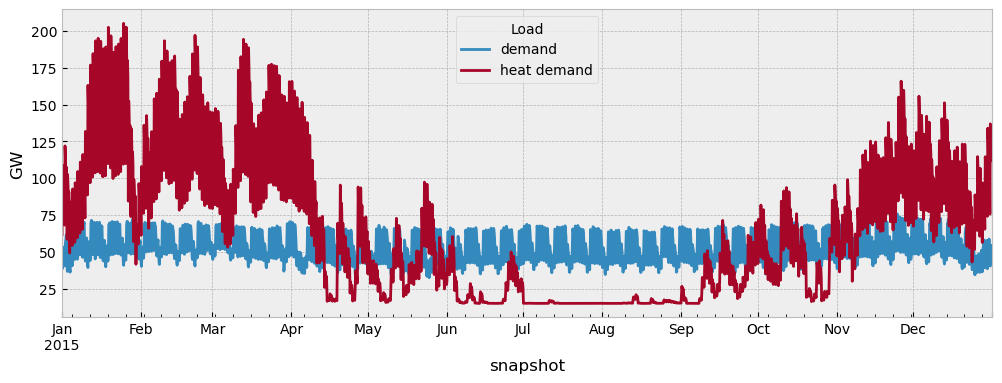

In [23]:
n.loads_t.p_set.div(1e3).plot(figsize=(12,4), ylabel='GW')

## Heat pumps

To model heat pumps, first we have to calculate the **coefficient of performance (COP)** profile based on the temperature profile of the heat source.

In the example below, we calculate the COP for an air-sourced heat pump with a sink temperature of 55° C and a population-weighted ambient temperature profile for Germany.

The heat pump performance is given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063^\Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.

In [24]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.000630 * delta_t**2

In [25]:
url = "https://tubcloud.tu-berlin.de/s/S4jRAQMP5Te96jW/download/ninja_weather_country_DE_merra-2_population_weighted.csv"
temp = pd.read_csv(url, skiprows=2, index_col=0, parse_dates=True).loc["2015", "temperature"][::4]

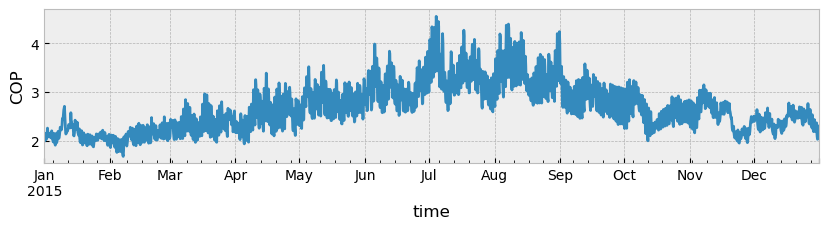

In [26]:
cop(temp).plot(figsize=(10,2), ylabel='COP');

Text(0, 0.5, 'COP [-]')

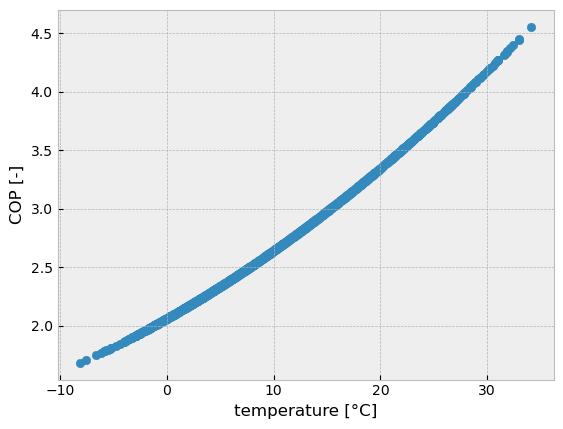

In [27]:
plt.scatter(temp, cop(temp))
plt.xlabel('temperature [°C]')
plt.ylabel('COP [-]')

Once we have calculated the heat pump coefficient of performance, we can add the heat pump to the network as a `Link`. We use the parameter `efficiency` to incorporate the COP.

In [28]:
n.add(
    "Link",
    "heat pump",
    carrier='heat pump',
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp),
    p_nom_extendable=True,
    capital_cost=3e5 # €/MWe/a
)

Let's also add a resistive heater as backup technology:

In [29]:
n.add(
    "Link",
    "resistive heater",
    carrier='resistive heater',
    bus0="electricity",
    bus1="heat",
    efficiency=0.9,
    capital_cost=1e4, # €/MWe/a
    p_nom_extendable=True,
)

## Combined Heat-and-Power (CHP)

In the following, we are going to add gas-fired combined heat-and-power plants (CHPs). Today, these would use fossil gas, but in the example below we assume green methane with relatively high marginal costs. Since we have no other net emission technology, we can remove the CO$_2$ limit.

In [30]:
n.remove("GlobalConstraint", "CO2Limit")

Then, we explicitly represent the energy carrier gas:

In [31]:
n.add("Bus", "gas", carrier="gas")

And add a `Store` of gas, which can be depleted (up to 100 TWh) with fuel costs of 150 €/MWh.

In [32]:
n.add(
    "Store",
    "gas storage",
    carrier="gas storage",
    e_initial=100e6, # MWh
    e_nom=100e6, # MWh
    bus="gas",
    marginal_cost=150, # €/MWh_th
)

When we do this, we have to model the OCGT power plant as link which converts gas to electricity, not as generator.

In [33]:
n.remove("Generator", "OCGT")

In [34]:
n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    carrier="OCGT",
    p_nom_extendable=True,
    capital_cost=20000, # €/MW/a
    efficiency=0.4,
)

Next, we are going to add a combined heat-and-power (CHP) plant with fixed heat-power ratio (i.e. backpressure operation). If you want to model flexible heat-power ratios, have a look at this example: https://pypsa.readthedocs.io/en/latest/examples/power-to-gas-boiler-chp.html

In [35]:
n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    carrier="CHP",
    p_nom_extendable=True,
    capital_cost=40000,
    efficiency=0.4,
    efficiency2=0.4,
)

## Electric Vehicles

To model electric vehicles, we first create another bus for the electric vehicles.

In [36]:
n.add("Bus", "EV", carrier="EV")

Then, we can attach the electricity consumption of electric vehicles to this bus:

In [37]:
url = "https://tubcloud.tu-berlin.de/s/9r5bMSbzzQiqG7H/download/electric-vehicle-profile-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

<Axes: xlabel='snapshot', ylabel='GW'>

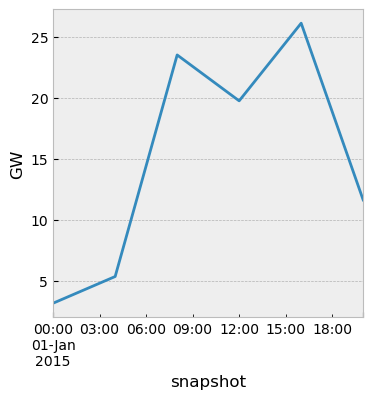

In [38]:
p_set.loc["2015-01-01"].div(1e3).plot(figsize=(4,4), ylabel='GW')

In [39]:
n.add(
    "Load",
    "EV demand",
    bus="EV",
    carrier="EV demand",
    p_set=p_set
)

Let's have a quick look at how the heat, electricity, constant hydrogen and electric vehicle demands relate to each other:

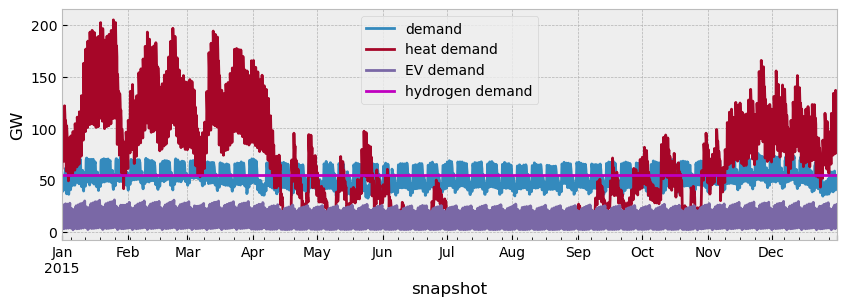

In [40]:
n.loads_t.p_set.div(1e3).plot(figsize=(10,3), ylabel='GW')
plt.axhline(n.loads.loc["hydrogen demand", "p_set"] / 1e3, label='hydrogen demand', color='m')
plt.legend()

The electric vehicles can only be charged when they are plugged-in. Below we load an availability profile
telling us what share of electric vehicles is plugged-in **at home** -- we only assume home charging in this example.

In [41]:
url = "https://tubcloud.tu-berlin.de/s/E3PBWPfYaWwCq7a/download/electric-vehicle-availability-example.csv"
availability_profile = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

<Axes: xlabel='snapshot'>

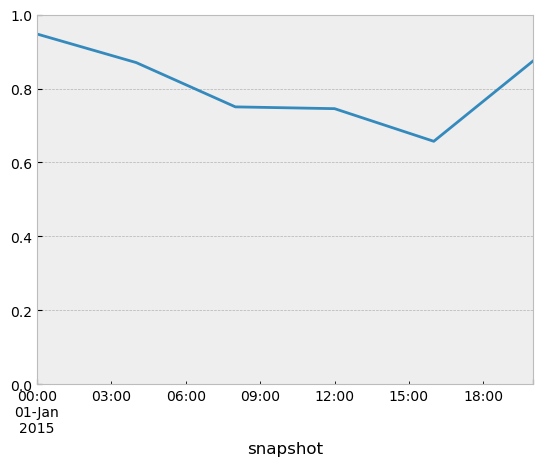

In [42]:
availability_profile.loc["2015-01-01"].plot(ylim=(0,1))

Then, we can add a link for the electric vehicle charger using assumption about the number of EVs and their charging rates.

In [43]:
number_cars = 40e6  #  number of EV cars
bev_charger_rate = 0.011  # 3-phase EV charger with 11 kW
p_nom = number_cars * bev_charger_rate

In [44]:
n.add(
    "Link",
    "EV charger",
    bus0="electricity",
    bus1="EV",
    p_nom=p_nom,
    carrier="EV charger",
    p_max_pu=availability_profile,
    efficiency=0.9,
)

We can also allow vehicle-to-grid operation (i.e. electric vehicles inject power into the grid):

In [45]:
n.add(
    "Link",
    "V2G",
    bus0="EV",
    bus1="electricity",
    p_nom=p_nom,
    carrier="V2G",
    p_max_pu=availability_profile,
    efficiency=0.9,
)

The demand-side management potential we model as a store. This is not unlike a battery storage, but we impose additional constraints on when the store needs to be charged to a certain level (e.g. 75% full every morning).

In [46]:
bev_energy = 0.05  # average battery size of EV in MWh
bev_dsm_participants = 0.5  # share of cars that do smart charging

e_nom = number_cars * bev_energy * bev_dsm_participants

In [47]:
url = "https://tubcloud.tu-berlin.de/s/K62yACBRTrxLTia/download/dsm-profile-example.csv"
dsm_profile = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

<Axes: xlabel='snapshot'>

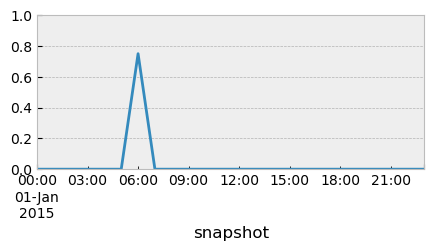

In [48]:
dsm_profile.loc["2015-01-01"].plot(figsize=(5,2), ylim=(0,1))

In [49]:
n.add(
    "Store",
    "EV DSM",
    bus="EV",
    carrier="EV battery",
    e_cyclic=True,  # state of charge at beginning = state of charge at the end
    e_nom=e_nom,
    e_min_pu=dsm_profile,
)

Then, we can solve the fully sector-coupled model altogether including electricity, passenger transport, hydrogen and heating.

In [50]:
n.lopf(solver_name='cbc')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+11


('ok', 'optimal')

In [51]:
n.statistics()

Capacity Factor  Capital Expenditure   
            carrier                                                  
Generator   offwind                  0.159939         3.606999e+09  \
            onwind                   0.012838         3.303204e+10   
            solar                    0.063811         3.532292e+10   
Link        CHP                           NaN         0.000000e+00   
            EV charger               0.035826         0.000000e+00   
            OCGT                          NaN         0.000000e+00   
            V2G                      0.000000         0.000000e+00   
            electrolysis             1.000000         3.905135e+09   
            fuel cell                     NaN         0.000000e+00   
            heat pump                     NaN         0.000000e+00   
            resistive heater         0.330618         2.277568e+09   
Load        -                             NaN                  NaN   
            EV demand                     NaN                  NaN   
            heat                          NaN                  NaN   
            hydrogen                      NaN                  NaN   
StorageUnit battery storage          0.101662         4.308868e+10   
Store       EV battery               0.000000         0.000000e+00   
            gas storage              1.000000         0.000000e+00   
            hydrogen storage         0.039875         1.810238e-08   

                               Curtailment  Installed Capacity   
            carrier                                              
Generator   offwind            4627.300990                 0.0  \
            onwind            66316.032450                 0.0   
            solar             45854.222888                 0.0   
Link        CHP                        NaN                 0.0   
            EV charger                 NaN            440000.0   
            OCGT                       NaN                 0.0   
            V2G                        NaN            440000.0   
            electrolysis               NaN                 0.0   
            fuel cell                  NaN                 0.0   
            heat pump                  NaN                 0.0   
            resistive heater           NaN                 0.0   
Load        -                          NaN                 NaN   
            EV demand                  NaN                 NaN   
            heat                       NaN                 NaN   
            hydrogen                   NaN                 NaN   
StorageUnit battery storage       0.000000                 0.0   
Store       EV battery                 NaN           1000000.0   
            gas storage                NaN         100000000.0   
            hydrogen storage           NaN                 0.0   

                              Operational Expenditure  Optimal Capacity   
            carrier                                                       
Generator   offwind                         72.968297      2.281124e+04  \
            onwind                        5958.027613      3.437762e+05   
            solar                          484.633963      7.594874e+05   
Link        CHP                              0.000000      0.000000e+00   
            EV charger                       0.000000      4.400000e+05   
            OCGT                             0.000000      0.000000e+00   
            V2G                              0.000000      4.400000e+05   
            electrolysis                     0.000000      7.810270e+04   
            fuel cell                        0.000000      0.000000e+00   
            heat pump                        0.000000      0.000000e+00   
            resistive heater                 0.000000      2.277568e+05   
Load        -                                     NaN               NaN   
            EV demand                             NaN               NaN   
            heat                               

<Axes: xlabel='None,carrier', ylabel='bn€/a'>

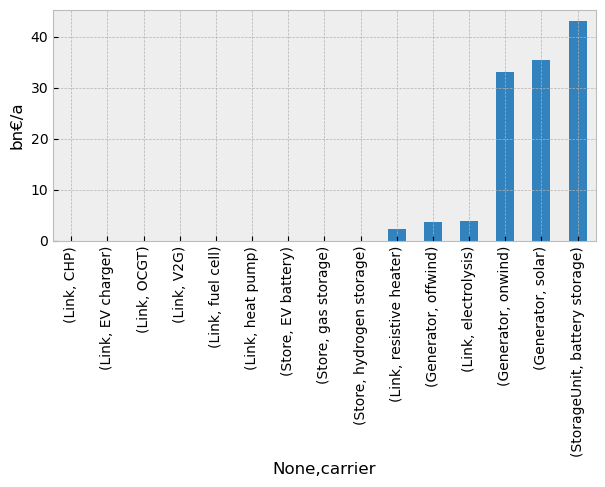

In [52]:
n.statistics()["Capital Expenditure"].div(1e9).sort_values().dropna().plot.bar(ylabel='bn€/a', cmap='tab20c', figsize=(7,3))

## Exercises

Here are a few things you can do to explore this system:

- exclude one of transport sector, heating sector, hydrogen demand and investigate what impact it has on system operation and investments
- vary the charging rates and availability profiles of electric vehicles